In [3]:
import SimpleITK as sitk

# Percorsi ai file DICOM
file_path_1 = 'Desktop/CT_dicom/CT.1.2.246.352.71.3.164087780.2233470.20130213140517.dcm'
file_path_2 = 'Desktop/CT_dicom/CT.1.2.246.352.71.3.164087780.2233471.20130213140517.dcm'

# Leggi i metadati dei file DICOM
metadata_reader = sitk.ImageFileReader()
metadata_reader.SetFileName(file_path_1)
metadata_reader.LoadPrivateTagsOn()
metadata_reader.ReadImageInformation()

sop_instance_uid_1 = metadata_reader.GetMetaData('0008|0018')
series_instance_uid_1 = metadata_reader.GetMetaData('0020|000e')

metadata_reader.SetFileName(file_path_2)
metadata_reader.ReadImageInformation()

sop_instance_uid_2 = metadata_reader.GetMetaData('0008|0018')
series_instance_uid_2 = metadata_reader.GetMetaData('0020|000e')

# Confronta i metadati per verificare se sono la stessa immagine
same_image = sop_instance_uid_1 == sop_instance_uid_2
same_series = series_instance_uid_1 == series_instance_uid_2

print(f"Sono lo stesso file immagine? {same_image}")
print(f"Fanno parte della stessa serie di immagini? {same_series}")

Sono lo stesso file immagine? False
Fanno parte della stessa serie di immagini? True


In [5]:
# Carica le immagini CT
# Sostituisci 'path_to_fixed_image' e 'path_to_moving_image' con i percorsi effettivi dei file delle immagini
fixed_image = sitk.ReadImage('Desktop/CT_dicom/CT.1.2.246.352.71.3.164087780.2233470.20130213140517.dcm', sitk.sitkFloat32)
moving_image = sitk.ReadImage('Desktop/CT_dicom/CT.1.2.246.352.71.3.164087780.2233471.20130213140517.dcm', sitk.sitkFloat32)

print(fixed_image.GetSize())
print(moving_image.GetSize())

(512, 512, 1)
(512, 512, 1)


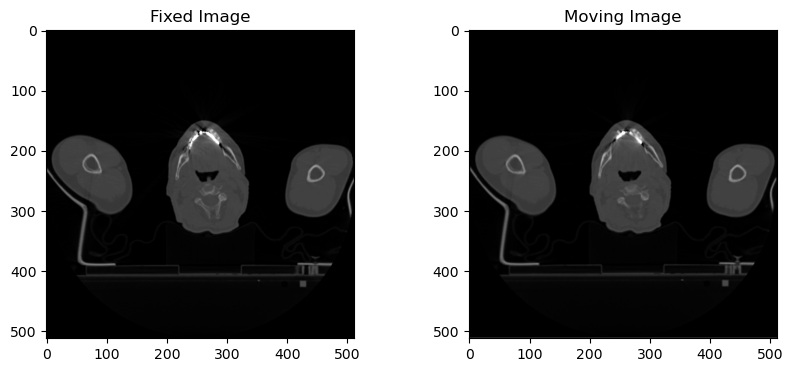

In [10]:
# Carica le immagini CT come 3D
fixed_image_3d = sitk.ReadImage('Desktop/CT_dicom/CT.1.2.246.352.71.3.164087780.2233470.20130213140517.dcm', sitk.sitkFloat32)
moving_image_3d = sitk.ReadImage('Desktop/CT_dicom/CT.1.2.246.352.71.3.164087780.2233471.20130213140517.dcm', sitk.sitkFloat32)

# Converte le immagini 3D in 2D, assumendo che la terza dimensione sia 1
fixed_image = sitk.Extract(fixed_image_3d, (fixed_image_3d.GetWidth(), fixed_image_3d.GetHeight(), 0), (0,0,0))
moving_image = sitk.Extract(moving_image_3d, (moving_image_3d.GetWidth(), moving_image_3d.GetHeight(), 0), (0,0,0))

# Inizializza la registrazione rigida 2D
registration_method = sitk.ImageRegistrationMethod()

# Metrica di similarità: Informazione Mutua
registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)

# Inizializza l'allineamento con un approccio di tipo centroide
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

# Ottimizzatore: Gradiente discendente
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, 
                                                  convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Trasformazione: Trasformazione rigida 2D (rotazione + traslazione)
transform_initial = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_method.SetInitialTransform(transform_initial)

# Interpolazione: Lineare
registration_method.SetInterpolator(sitk.sitkLinear)

# Esegui la registrazione
final_transform = registration_method.Execute(fixed_image, moving_image)

# Applica la trasformazione finale per allineare l'immagine in movimento a quella fissa
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# Applica la trasformazione finale per allineare l'immagine in movimento a quella fissa
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelID())

# Converti l'immagine in virgola mobile in un'immagine intera prima di salvarla
moving_resampled_int = sitk.Cast(sitk.RescaleIntensity(moving_resampled), sitk.sitkInt16)

# Salva l'immagine risultante come file DICOM
sitk.WriteImage(moving_resampled_int, 'Desktop/CT_dicom/fixed_registered_image.dcm')

# Visualizza l'allineamento 
import matplotlib.pyplot as plt

# Funzione helper per visualizzare le immagini affiancate
def show_images_side_by_side(fixed_img, moving_img):
    img1 = sitk.GetArrayFromImage(fixed_img)
    img2 = sitk.GetArrayFromImage(moving_img)

    # In caso di immagini 2D, non c'è bisogno di indicizzare una fetta
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')  # Usa direttamente l'array 2D
    plt.title('Fixed Image')

    plt.subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')  # Usa direttamente l'array 2D
    plt.title('Moving Image')

    plt.show()

# Visualizza l'immagine fissa e quella in movimento allineata
show_images_side_by_side(fixed_image, moving_resampled)

In [11]:
import numpy as np
# Supponiamo che 'fixed_image' e 'moving_resampled' siano le immagini che hai già registrato

# Creazione di un'immagine delle differenze
difference_image = sitk.Subtract(fixed_image, moving_resampled)

# Calcolo della metrica di similarità per la valutazione quantitativa
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMeanSquares()  # Ad esempio, Mean Squares
metric_value = registration_method.MetricEvaluate(fixed_image, moving_resampled)

# Visualizzazione dell'immagine delle differenze
difference_array = sitk.GetArrayFromImage(difference_image)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sitk.GetArrayFromImage(fixed_image), cmap='gray')
plt.title('Fixed Image')
plt.subplot(1, 2, 2)
plt.imshow(difference_array, cmap='gray')
plt.title('Difference Image')
plt.show()

RuntimeError: Exception thrown in SimpleITK ImageRegistrationMethod_MetricEvaluate: /tmp/SimpleITK/Code/Registration/src/sitkImageRegistrationMethod.cxx:1099:
sitk::ERROR: Unexpected error converting initial transform! Possible miss matching dimensions!